# Chemical reactor optimization

This notebook introduces the optimization of a continuous stirred tank reactor (CSTR) with a requirement of time-varying output composition. The dummy case consists of a catalytic reaction $A + s \rightarrow B + C + s$ where $s$ denotes a surface site where reaction takes place with rate constant $k$. Reagent and products are diluted in inert species $D$. Composition can be controlled through dilution with increased flow rate $q$ of species $D$ or injection of species $A$ with flow rate $u$. In what follows details of problem implementation are exposed progressivelly.

We start by importing the required packages. Problem is built and tested with `casadi` and `opengen` is used to generate a deployable version which can be hosted in a server to control the actual tank.

In [1]:
import numpy as np
import casadi as cs
import opengen as og
import matplotlib.pyplot as plt

%matplotlib inline

The tank reactor is assumed to have a volume comporting `n = 500` moles of matter. Catalyst integral constant (rate constant multiplied by area) is set to `k = 100` in units of mole per second. These values together specify the main dimensions of the problem.

In [2]:
n = 500.0
k = 100.0

The system is equipped with two fluid sources $u$ for species $A$ and $q$ for species $D$. For safety reasons flow $q$ cannot be set below `qmin = 4` moles per second and its maximum capacity is `qmax = 9` moles per second. Flow of $A$ is limited to `umax = 1`. Variables `xq` and `xu` are introduced to store the composition of these pure species sources, with mole fractions ordered as $A$, $B$, $C$, and $D$. We also declare the symbolic variables for these flow rates.

In [3]:
qmin = 4.0
qmax = 9.0

umin = 0.0
umax = 1.0

xq = cs.vertcat(0.00, 0.00, 0.00, 1.00)
xu = cs.vertcat(1.00, 0.00, 0.00, 0.00)

q = cs.SX.sym("q")
u = cs.SX.sym("u")

Also for safety reasons, our dummy process cannot contain more than 5% of each of species $A$, $B$, and $C$. Ranges of minimum and maximum values for each species in system are given by `xmin` and `xmax` next.

In [4]:
xmin = [0.00, 0.00, 0.00, 0.90]
xmax = [0.05, 0.05, 0.05, 1.00]

The fluid is composed of `ns = 4` chemical species as stated in introduction. Given the time-scales involved in the problem, a control loop with measurements being performed every `tau = 5` seconds is a good choice (you can study problem sensitivity by changing this value later). A horizon of prediction of 30 minutes given the expected transient times of $3V/Q\approx300$ seconds seems reasonable to be able to illustrate at least a pair of managed transitions.

In [5]:
ns = 4
nt = 360
tau = 5

System chemical composition is stored in `x` under the same order as `xq` or `xu`.

In [6]:
x = cs.SX.sym("x", ns)

Reaction rate depends only on species $A$ at `x[0]` and is irreversible. Generation rate `wdot` (often noted $\dot{\omega}$ in literature) of each species depends on its stoichiometric coefficient on the afore mentionned reaction and can be computed as follows.

In [7]:
rate = k * x[0]
wdot = cs.vertcat(-1, 1, 1, 0) * rate

Assuming system outlet does not promote any resistance to flow variations such that it is possible to keep the system at fixed size `n` and given the fact that the catalysis reaction generates two moles of product for each mole of precursor $A$ (thus generates and expantion), one writes the balance equation to computing the vector derivatives with all species as:

$$
\dot{x}=\dfrac{\sum{x_{F}F} - (\sum{F}+\Delta\nu\dot{\omega})x + \dot{\omega}}{n}
$$

where $F$ denotes a flow with composition $x_{F}$ and $\Delta\nu$ is the variation of number of moles in reaction. Notice the inertia of system given by its size is given by the number of moles $n$. Expanding with our symbol convention this can be rewritten as:

$$
\dot{x}=\dfrac{x_{q}q + x_{u}u- (q + u + \dot{\omega})x + \dot{\omega}}{n}
$$

Since everything was already programmed in a vectorized for, this expression can be written as follows:

In [8]:
xdot = (xq * q + xu * u - (q + u + rate) * x + wdot) / n

Using `casadi.Function` constructor this expression can be encapsulated in `f` to be evaluated with different inputs, whether numerically or symbolically. We make use of this powerful feature to compose value of the composition at the end of a time-step `tau` by writing down a Runge-Kutta 4th order stepping function `F`.

In [9]:
f = cs.Function("f", [x, q, u], [xdot])

k1 = f(x, q, u)
k2 = f(x + tau * k1 / 2, q, u)
k3 = f(x + tau * k2 / 2, q, u)
k4 = f(x + tau * k3, q, u)

rets = [x + tau * (k1 + 2 * k2 + 2 * k3 + k4) / 6]
F = cs.Function("F", [x, q, u], rets)

Next we declare our known parameters upon which the problem will be built. These include the time-dependent set-point vector of species $B$ given by `xs` (notice its size is `np`, with a value provided for each time point in the prediction horizon), the initial composition `x0`, and flow rates, `q0` and `u0`.

In [10]:
xs = cs.SX.sym("xs", nt)
x0 = cs.SX.sym("x0", ns)
q0 = cs.SX.sym("q0")
u0 = cs.SX.sym("u0")

Although until now the formulation has been fully based on system mass balance, we need to introduce some numerical parameters to control how the optimization with penalize different things. First, we want to control the output content of species $B$, so the square of error with regards to set-point is computed. To this error we give a unit weight through vector `Q`. Nothing impeaches us of using a different profile, *e.g.* increasing the weight over time might be interesting in certain scenarios, but for our introductory purpose a constant weight is enough. 

Another penalty to be added to cost function are the rate of changes in commands `q` and `u`. To provide smooth operation the change in these set-points must provide additional cost so that they do not vary wildely, what is done here through `R` and `S`, respectivelly. If the order of magnitude of the variables changes too much, then one must consider choosing proper scales to these different weights, but that is not the case here.

In [11]:
Q = cs.GenDM_ones(nt)
R = cs.GenDM_ones(nt) * 0.5
S = cs.GenDM_ones(nt) * 0.5

## Multiple-shooting solution

This preparation allows us to start the problem integration over time. We create symbolic variables for those to be found by the optimizer and add then to list `x`. Since their values are fixed (initial conditions) in the first step, generally we should set the lower and upper boundaries `lbx` and `ubx` to the same value and equal to initial conditions. Because symbolic parameters are not supported by `casadi` in these bounds lists and we want to create a deployable version of the model with `opengen`, we use the default bounds for these variables and add constraints in list `g` to enforce initial state. That might look odd if you have already gone through sample cases provided by `casadi`.

In [12]:
xj = cs.SX.sym("x0", ns)
qj = cs.SX.sym("q0")
uj = cs.SX.sym("u0")

x = [xj, qj, uj]
lbx = [*xmin, qmin, umin]
ubx = [*xmax, qmax, umax]

g = []
g.append(xj - x0)
g.append(qj - q0)
g.append(uj - u0)

Next we initialize cost `f = 0` and loop from step one to the end `np` making use of `F` to predict the value at current step which is used to compute the cost related to error of species `B` at `x[1]`. After the first step we also add penalties to the controls `q` and `u`. In each step of the loop we create new symbols for the unknowns, extend the list `x` and the bounds and enforce the previous prediction to be equal the new symbols, what consists the method of multiple-shooting.

In [13]:
f = 0

for j in range(1, nt):
    xj = F(xj, qj, uj)
    f += Q[j] * pow(xj[1] - xs[j], 2)

    if j != 1:
        f += R[j] * pow(qj - qj_prev, 2)
        f += S[j] * pow(uj - uj_prev, 2)

    xj_prev = xj
    qj_prev = qj
    uj_prev = uj

    xj = cs.SX.sym(F"x{j}", ns)
    qj = cs.SX.sym(F"q{j}")
    uj = cs.SX.sym(F"u{j}")

    x.extend([xj, qj, uj])
    lbx.extend([*xmin, qmin, umin])
    ubx.extend([*xmax, qmax, umax])

    g.append(xj_prev - xj)

The problem is assembled and we can now create a solver with `casadi.nlpsol`. Free variables to be provide by end-user are concatenated in `p` in the dictionary of problem constructor. For solution we make use of `ipopt` optimizer.

In [14]:
nlp = {
    "f": f,
    "x": cs.vertcat(*x),
    "g": cs.vertcat(*g),
    "p": cs.vertcat(xs, x0, q0, u0)
}

solver = cs.nlpsol("solver", "ipopt", nlp)

## Sample test case

Now we can use the solver with actual numeric values. For the set-point of species $B$ we provide a stepwise profile at three different concentrations. System is initialized to be filled with pure compound $D$ fed alone by its source $q$. Stacking the parameters in the same order as used in problem construction one can call the solver as follows.

In [15]:
xs_num = cs.GenDM_ones(nt).full().ravel() * 2 / 100
xs_num[1*nt//3:] *= 3.0
xs_num[2*nt//3:] *= 0.0

x0_num = [0.00, 0.00, 0.00, 1.00]
q0_num = 5.0
u0_num = 0.0

p = cs.vertcat(xs_num, x0_num, q0_num, u0_num)
sol = solver(p=p, lbx=lbx, ubx=ubx, lbg=0, ubg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     6827
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     6460

Total number of variables............................:     2160
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2160
                     variables with only upper bounds:        0
Total number of equa

Solution is found in `sol["x"]` array. Below we unpack the variables. Since we have 4 chemical species and 2 controls parameters, slicing the array every 6 entries starting by the variable index allows us to retrieve the variables. Since the way the multiple shooting loop was written does not enforce anything for the last controls, the last value has no meaning and we over write it with its predecessor just for having nice graphics.

In [16]:
t = cs.linspace(0.0, nt * tau, nt)
x = sol["x"].full().ravel()

A = x[0::6] * 100
B = x[1::6] * 100
C = x[2::6] * 100
D = x[3::6] * 100
q = x[4::6]
u = x[5::6]

q[-1] = q[-2]
u[-1] = u[-2]

It is now simply a matter of plotting. For species $B$ we add a line for the set-point for comparison.

In [17]:
def plot_results(t, A, B, C, D, q, u, xs_num):
    """ Display optimization results. """
    plt.close("all")
    plt.style.use("seaborn-white")
    fig, ax = plt.subplots(3, 2, figsize=(12, 8), sharex=True)

    ax[0, 0].plot(t, A, label="PV")
    ax[0, 1].plot(t, B, label="PV")
    ax[0, 1].step(t, 100 * xs_num, label="SP")
    ax[1, 0].plot(t, C, label="PV")
    ax[1, 1].plot(t, D, label="PV")
    ax[2, 0].step(t, q, label="PV")
    ax[2, 1].step(t, u, label="PV")

    ax[0, 0].grid(linestyle=":")
    ax[0, 1].grid(linestyle=":")
    ax[1, 0].grid(linestyle=":")
    ax[1, 1].grid(linestyle=":")
    ax[2, 0].grid(linestyle=":")
    ax[2, 1].grid(linestyle=":")

    ax[0, 0].legend(loc=1)
    ax[0, 1].legend(loc=1)
    ax[1, 0].legend(loc=1)
    ax[1, 1].legend(loc=1)
    ax[2, 0].legend(loc=1)
    ax[2, 1].legend(loc=1)

    ax[0, 0].set_ylabel("Content of A [%]")
    ax[0, 1].set_ylabel("Content of B [%]")
    ax[1, 0].set_ylabel("Content of C [%]")
    ax[1, 1].set_ylabel("Content of D [%]")
    ax[2, 0].set_ylabel("Flow rate of D [mol/s]")
    ax[2, 1].set_ylabel("Flow rate of A [mol/s]")

    ax[0, 0].set_xlim(0, nt * tau)
    ax[0, 1].set_xlim(0, nt * tau)
    ax[1, 0].set_xlim(0, nt * tau)
    ax[1, 1].set_xlim(0, nt * tau)
    ax[2, 0].set_xlim(0, nt * tau)
    ax[2, 1].set_xlim(0, nt * tau)

    plt.setp(ax[0, 0].get_xticklabels(), visible=False)
    plt.setp(ax[0, 1].get_xticklabels(), visible=False)
    plt.setp(ax[1, 0].get_xticklabels(), visible=False)
    plt.setp(ax[1, 1].get_xticklabels(), visible=False)

    fig.tight_layout()

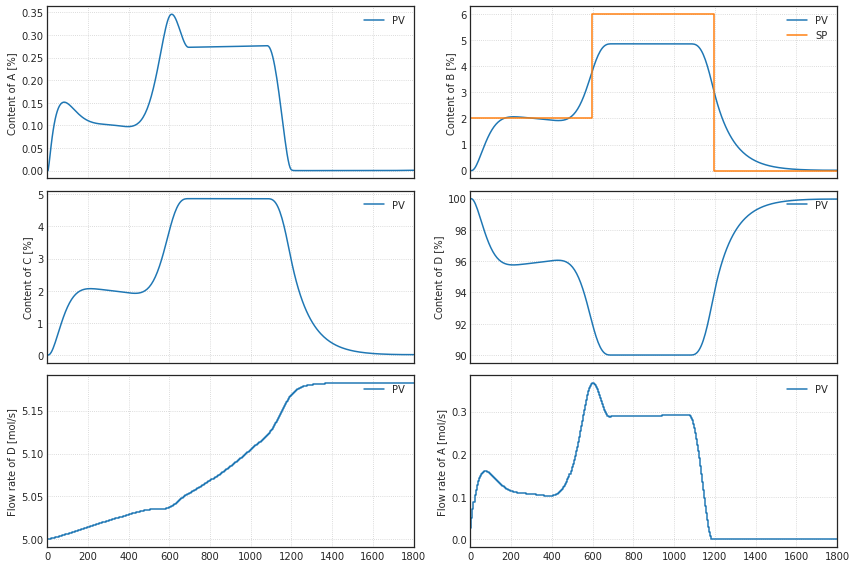

In [18]:
plot_results(t, A, B, C, D, q, u, xs_num)

## TCP interface generation

In [ ]:
# This is an alternative version for same problem:
# problem=og.builder.Problem(nlp["x"], nlp["p"], nlp["f"])
#     .with_penalty_constraints(nlp["g"])
#     .with_constraints(og.constraints.Rectangle(xmin=lbx, xmax=ubx)),

builder = og.builder.OpEnOptimizerBuilder(
    problem=og.builder.Problem(nlp["x"], nlp["p"], nlp["f"])
        .with_aug_lagrangian_constraints(nlp["g"], og.constraints.Zero())
        .with_penalty_constraints(nlp["g"])
        .with_constraints(og.constraints.Rectangle(xmin=lbx, xmax=ubx)),
    metadata=og.config.OptimizerMeta()
        .with_version("0.1.0")
        .with_authors(["W. Dal'Maz Silva"])
        .with_licence("CC4.0-By")
        .with_optimizer_name("cstr_optim"),
    build_configuration=og.config.BuildConfiguration()
        .with_build_directory("python_build")
        .with_build_mode("release")
        .with_tcp_interface_config()
        .with_build_python_bindings()
        .with_rebuild(True),
    solver_configuration=og.config.SolverConfiguration()
        .with_delta_tolerance(1.0e-07)
        .with_initial_penalty(1000.0)
        .with_initial_tolerance(1.0e-06)
        .with_max_duration_micros(1_000_000)
        .with_max_inner_iterations(5000)
        .with_max_outer_iterations(5000)
        .with_penalty_weight_update_factor(10.0)
        .with_tolerance(1.0e-06)
        .with_lbfgs_memory(20)
)
builder.build()

In [ ]:
# sys.path.insert(0, "python_build/cstr_optim")

# import cstr_optim

# solver = cstr_optim.solver()
# result = solver.run(p=p.full().ravel().tolist())
# u_star = result.solution

# result.exit_status

# A = np.array(u_star[0::6]) * 100
# B = np.array(u_star[1::6]) * 100
# C = np.array(u_star[2::6]) * 100
# D = np.array(u_star[3::6]) * 100
# q = u_star[4::6]
# u = u_star[5::6]

# q[-1] = q[-2]
# u[-1] = u[-2]

# plot_results(t, A, B, C, D, q, u, xs_num)

Now run `RUST_LOG=tcp_iface=info cargo run` from TCP interface directory.

In [ ]:
# mng = og.tcp.OptimizerTcpManager("python_build/cstr_optim")

# response = mng.call(p.full().ravel().tolist())

# if response.is_ok():
#     solution_data = response.get()
#     u_star = solution_data.solution
#     exit_status = solution_data.exit_status
#     solver_time = solution_data.solve_time_ms
#     print(exit_status, solver_time)
# else:
#     solver_error = response.get()
#     error_code = solver_error.code
#     error_msg = solver_error.message
#     print(error_msg, error_code)

# A = np.array(u_star[0::6]) * 100
# B = np.array(u_star[1::6]) * 100
# C = np.array(u_star[2::6]) * 100
# D = np.array(u_star[3::6]) * 100
# q = u_star[4::6]
# u = u_star[5::6]

# q[-1] = q[-2]
# u[-1] = u[-2]

# plot_results(t, A, B, C, D, q, u, xs_num)